# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
# initial Pyspark session
print("Welcome to my EMR Notebook!")

VBox()

Starting Spark application


In [ ]:
%%info

In [ ]:
# list pyspark packages
sc.list_packages()

In [ ]:
# install common libraries
sc.install_pypi_package("pandas")

In [ ]:
sc.install_pypi_package("matplotlib")

In [ ]:
sc.install_pypi_package("seaborn")

In [ ]:
# import libraries
# Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
# CommonLibraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# Pyspark ML Library
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
# replace event_data with local mini_sparkify_event_data.json
event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [138]:
# measure the shape of dataset
(df.count(), len(df.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(286500, 18)

In [139]:
# it seems artist,length,song have 228108
# firstName, lastName, gender, location, registration,userAgent have 278154
# userID has empty strings
df.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [10]:
# look at userId and sessionId
df.createOrReplaceTempView('sparkify')
spark.sql(
    '''
    SELECT DISTINCT userId
    FROM sparkify
    ORDER BY userId
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

In [142]:
spark.sql(
    '''
    SELECT DISTINCT sessionId
    FROM sparkify
    ORDER BY sessionId
    '''
).show()

# no blank for session

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows

In [11]:
# remove empty userid & session id
clean_sql = spark.sql(
    '''
    SELECT *
    FROM sparkify
    WHERE userId != '' and sessionId IS NOT null
    '''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [144]:
clean_sql.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [145]:
# we verified some missing records are non-users
# records with no songs means idle log-in time
clean_sql.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+---------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+---------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|            228108|278154|           278154|278154| 278154|      

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [146]:
# look at columns
df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']

In [12]:
# Artist
clean_sql.createOrReplaceTempView('clean_sql')
spark.sql(
    '''
    SELECT DISTINCT artist
    FROM clean_sql
    ORDER BY artist
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows

In [148]:
group_artist = spark.sql(
    '''
    SELECT artist, count(*) as count
    FROM clean_sql
    WHERE artist IS NOT null
    GROUP BY artist
    ORDER BY count(*) desc
    LIMIT 10
    '''
).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

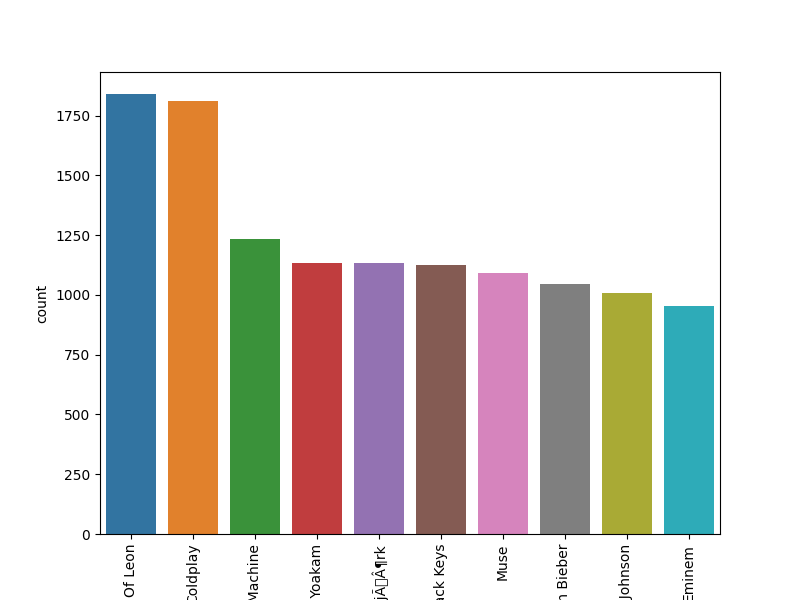

In [149]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x='artist', y='count', data=group_artist)
plt.xticks(rotation=90)
%matplot plt

In [150]:
# Auth
spark.sql(
    '''
    SELECT DISTINCT auth
    FROM clean_sql
    ORDER BY auth
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

In [151]:
group_auth = spark.sql(
    '''
    SELECT auth, count(*) as count
    FROM clean_sql
    GROUP BY auth
    ORDER BY count(*) desc
    '''
).toPandas()

group_auth

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        auth   count
0  Logged In  278102
1  Cancelled      52

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

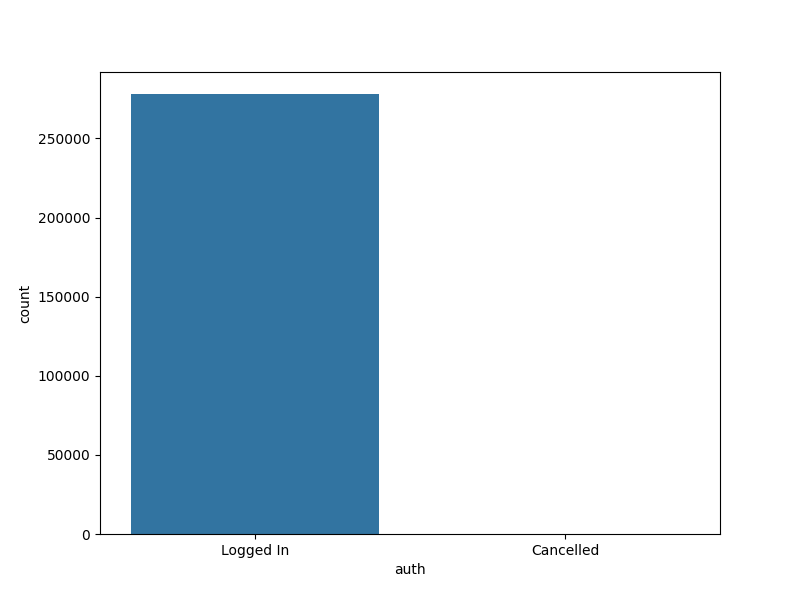

In [152]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x='auth', y='count', data=group_auth)
plt.show()
%matplot plt

In [153]:
# Gender
spark.sql(
    '''
    SELECT DISTINCT gender
    FROM clean_sql
    ORDER BY gender
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|gender|
+------+
|     F|
|     M|
+------+

In [154]:
group_gender = spark.sql(
    '''
    SELECT gender, count(*) as count
    FROM clean_sql
    GROUP BY gender
    ORDER BY count(*) desc
    '''
).toPandas()

group_gender

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  gender   count
0      F  154578
1      M  123576

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

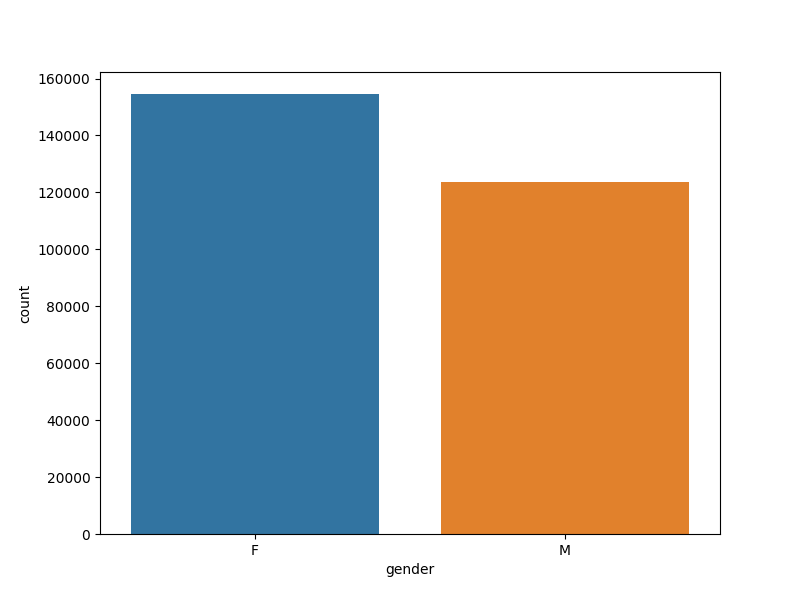

In [155]:
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='count', data=group_gender)
plt.show()
%matplot plt

In [156]:
# for gender, we'd better look at unique users
group_gender = spark.sql(
    '''
    SELECT gender, count(DISTINCT userId) as count
    FROM clean_sql
    GROUP BY gender
    ORDER BY count(*) desc
    '''
).toPandas()

group_gender

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  gender  count
0      F    104
1      M    121

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

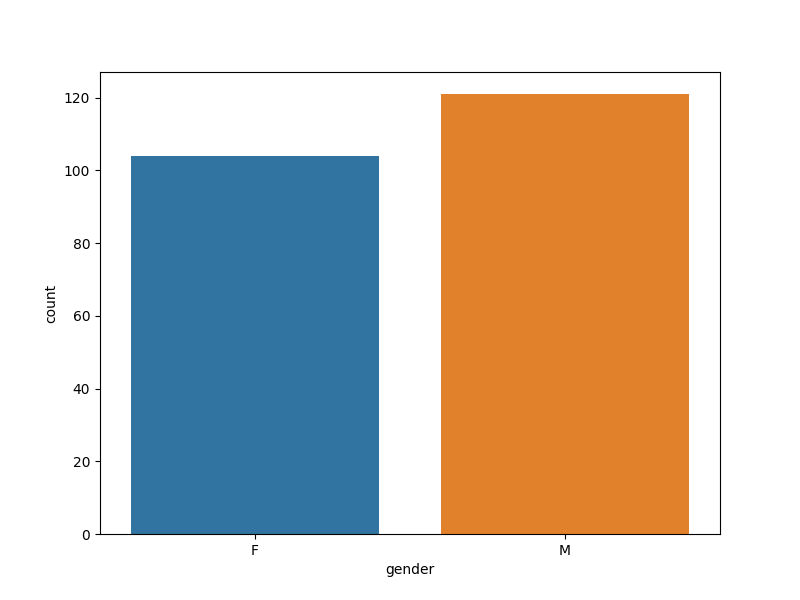

In [157]:
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='count', data=group_gender)
plt.show()
%matplot plt

In [158]:
# Level
spark.sql(
    '''
    SELECT DISTINCT level
    FROM clean_sql
    ORDER BY level
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|level|
+-----+
| free|
| paid|
+-----+

In [159]:
# look at distinct users
group_level = spark.sql(
    '''
    SELECT level, count(DISTINCT userId) as count
    FROM clean_sql
    GROUP BY level
    ORDER BY count(*) desc
    '''
).toPandas()

group_level

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  level  count
0  paid    165
1  free    195

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

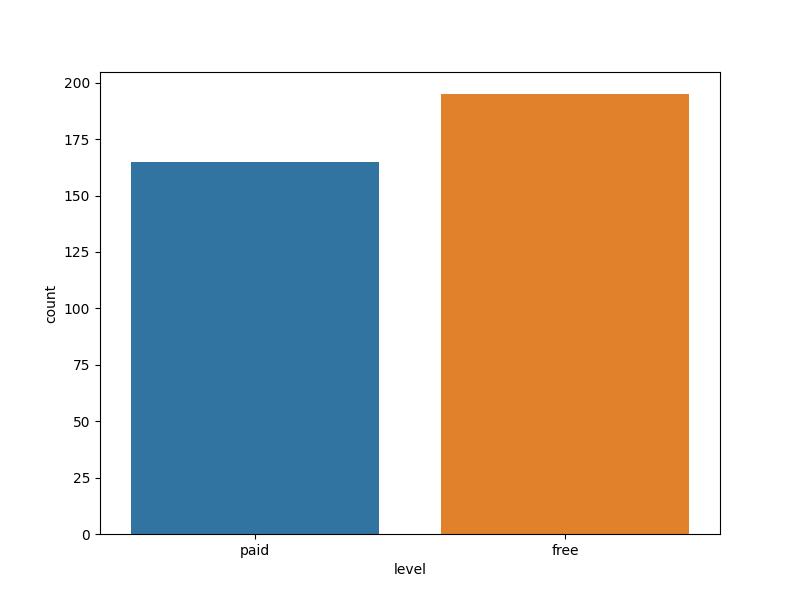

In [160]:
plt.figure(figsize=(8,6))
sns.barplot(x='level', y='count', data=group_level)
plt.show()
%matplot plt

In [161]:
# Location
spark.sql(
    '''
    SELECT DISTINCT location
    FROM clean_sql
    ORDER BY location
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            location|
+--------------------+
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
|Cincinnati, OH-KY-IN|
+--------------------+
only showing top 20 rows

In [162]:
group_location = spark.sql(
    '''
    SELECT location, count(*) as count
    FROM clean_sql
    GROUP BY location
    ORDER BY count(*) desc
    LIMIT 10
    '''
).toPandas()

group_location

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                      location  count
0           Los Angeles-Long Beach-Anaheim, CA  30131
1        New York-Newark-Jersey City, NY-NJ-PA  23684
2               Boston-Cambridge-Newton, MA-NH  13873
3         Houston-The Woodlands-Sugar Land, TX   9499
4            Charlotte-Concord-Gastonia, NC-SC   7780
5              Dallas-Fort Worth-Arlington, TX   7605
6           Louisville/Jefferson County, KY-IN   6880
7  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD   5890
8           Chicago-Naperville-Elgin, IL-IN-WI   5114
9                             St. Louis, MO-IL   4858

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

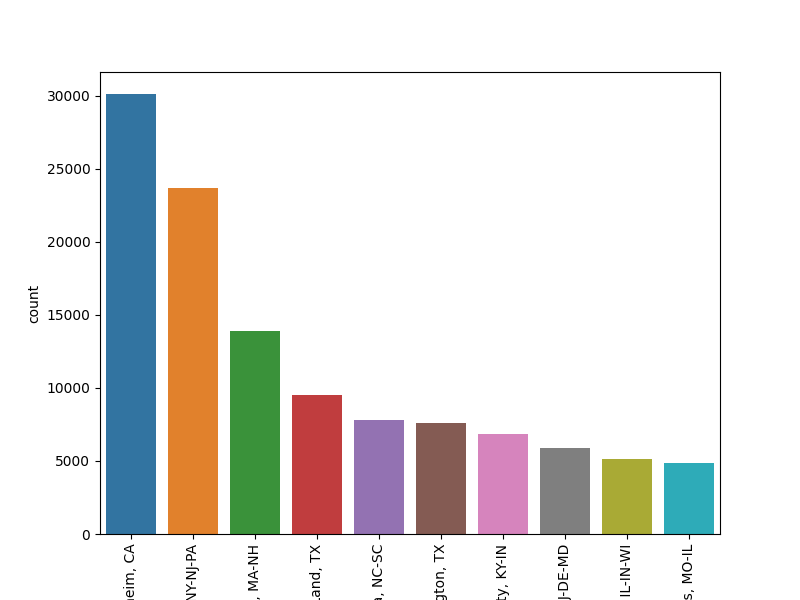

In [163]:
plt.figure(figsize=(8,6))
sns.barplot(x='location', y='count', data=group_location)
plt.xticks(rotation=90)
plt.show()
%matplot plt

In [164]:
# method
spark.sql(
    '''
    SELECT DISTINCT method
    FROM clean_sql
    ORDER BY method
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|method|
+------+
|   GET|
|   PUT|
+------+

In [165]:
group_method = spark.sql(
    '''
    SELECT method, count(*) as count
    FROM clean_sql
    GROUP BY method
    ORDER BY count(*) desc
    '''
).toPandas()

group_method

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  method   count
0    PUT  257818
1    GET   20336

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

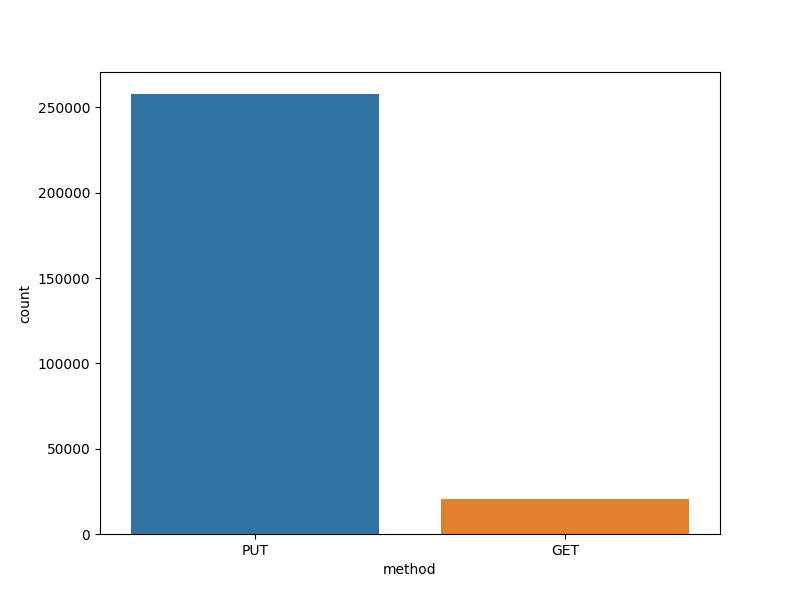

In [166]:
plt.figure(figsize=(8,6))
sns.barplot(x='method', y='count', data=group_method)
plt.show()
%matplot plt

In [167]:
# Page
spark.sql(
    '''
    SELECT DISTINCT page
    FROM clean_sql
    ORDER BY page
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+

In [168]:
group_page=spark.sql('''
    SELECT page, count(*) as count
    FROM clean_sql
    GROUP BY page
    ORDER BY count(*) desc
    LIMIT 5
    '''
    ).toPandas()

group_page

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              page   count
0         NextSong  228108
1        Thumbs Up   12551
2             Home   10082
3  Add to Playlist    6526
4       Add Friend    4277

In [169]:
spark.sql(
    '''
    SELECT page, count(*) as count
    FROM clean_sql
    GROUP BY page
    ORDER BY count(*) desc
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

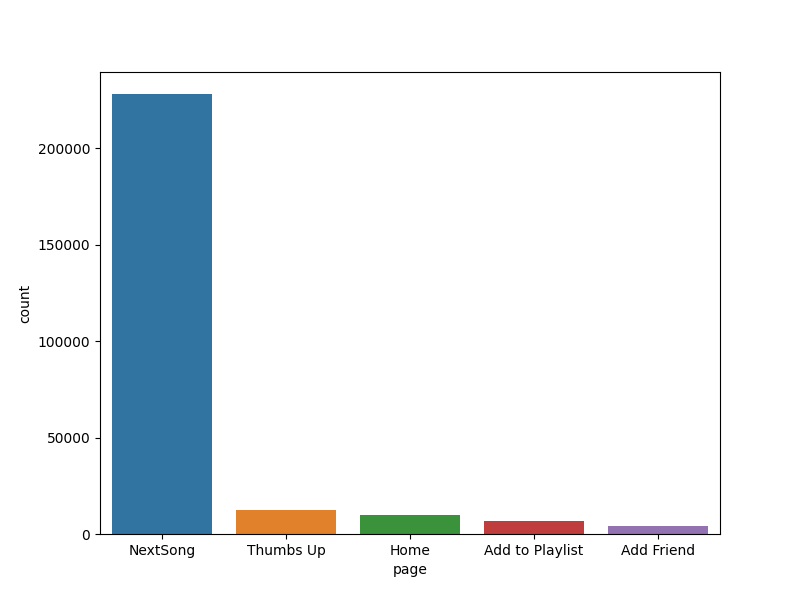

In [170]:
plt.figure(figsize=(8,6))
sns.barplot(x='page', y='count', data=group_page)
plt.show()
%matplot plt

In [171]:
# Song
spark.sql(
    '''
    SELECT DISTINCT song
    FROM clean_sql
    ORDER BY song
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
+--------------------+
only showing top 20 rows

In [172]:
group_song = spark.sql(
    '''
    SELECT song, count(*) as count
    FROM clean_sql
    WHERE song IS NOT null
    GROUP BY song
    ORDER BY count(*) DESC
    LIMIT 10
    '''
).toPandas()

group_song

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                song  count
0                                     You're The One   1153
1                                               Undo   1026
2                                            Revelry    854
3                                      Sehr kosmisch    728
4  Horn Concerto No. 4 in E flat K495: II. Romanc...    641
5                     Dog Days Are Over (Radio Edit)    574
6                                            Secrets    466
7                                       Use Somebody    459
8                                             Canada    435
9                                            Invalid    424

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

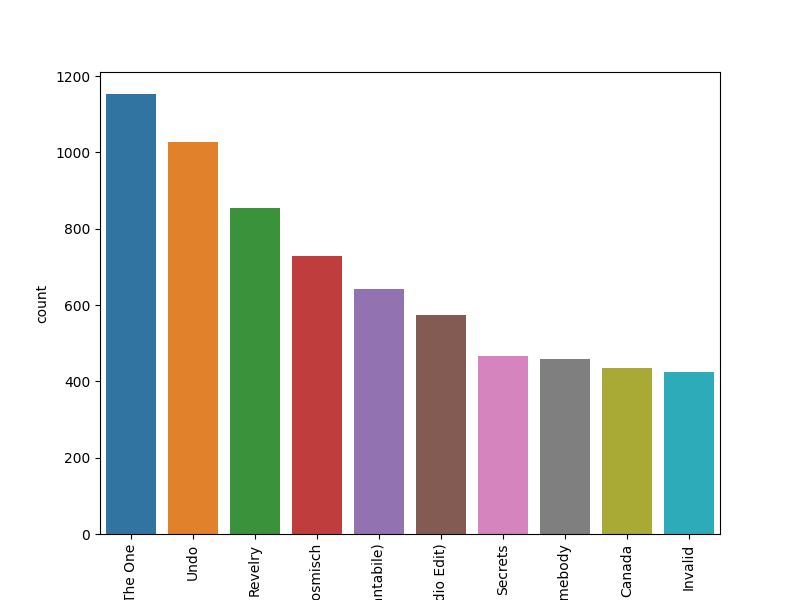

In [173]:
plt.figure(figsize=(8,6))
sns.barplot(x='song', y='count', data=group_song)
plt.xticks(rotation=90)
%matplot plt

In [174]:
# userAgent
spark.sql(
    '''
    SELECT DISTINCT userAgent
    FROM clean_sql
    ORDER BY userAgent
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows

In [175]:
group_agent = spark.sql(
    '''
    SELECT userAgent, count(*) as count
    FROM clean_sql
    GROUP BY userAgent
    ORDER BY count(*) DESC
    LIMIT 10
    '''
).toPandas()

group_agent

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                           userAgent  count
0  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...  22751
1  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...  19611
2  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...  18448
3  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...  17348
4  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...  16700
5  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...  15395
6  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...  14598
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...  10300
8  "Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...   8912
9  Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...   8624

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

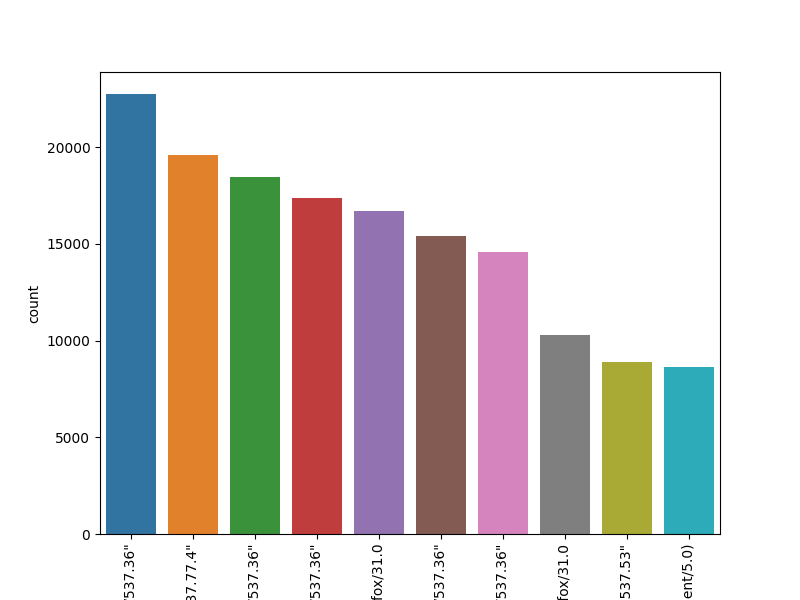

In [176]:
plt.figure(figsize=(8,6))
sns.barplot(x='userAgent', y='count', data=group_agent)
plt.xticks(rotation=90)
%matplot plt

In [13]:
# DataTime Conversion
datetime = udf(lambda x: dt.datetime.fromtimestamp(
    int(x) / 1000).strftime("%Y-%m-%d %H:%M:%S"))
year = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).year)
month = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).month)
weekday = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).weekday())
day = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).day)
hour = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).hour)

spark.udf.register('datetime', datetime)
spark.udf.register('year', year)
spark.udf.register('month', month)
spark.udf.register('weekday', weekday)
spark.udf.register('day', day)
spark.udf.register('hour', hour)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fa89c34e0d0>

In [14]:
datetime_data = spark.sql(
    '''
    SELECT userId,
        datetime(registration) AS datetime_registration,
        page,
        datetime(ts) AS datetime_page,
        CAST(year(ts) AS INT) AS year,
        CAST(month(ts) AS INT) AS month,
        CAST(weekday(ts) AS INT) AS weekday,
        CAST(day(ts) AS INT) AS day,
        CAST(hour(ts) AS INT) AS hour
    FROM clean_sql
    '''
)

datetime_data.createOrReplaceTempView('datetime_data')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [179]:
datetime_data.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------------------+---------------+-------------------+----+-----+-------+---+----+
|userId|datetime_registration|           page|      datetime_page|year|month|weekday|day|hour|
+------+---------------------+---------------+-------------------+----+-----+-------+---+----+
|    30|  2018-09-28 22:22:42|       NextSong|2018-10-01 00:01:57|2018|   10|      0|  1|   0|
|     9|  2018-09-30 18:20:30|       NextSong|2018-10-01 00:03:00|2018|   10|      0|  1|   0|
|    30|  2018-09-28 22:22:42|       NextSong|2018-10-01 00:06:34|2018|   10|      0|  1|   0|
|     9|  2018-09-30 18:20:30|       NextSong|2018-10-01 00:06:56|2018|   10|      0|  1|   0|
|    30|  2018-09-28 22:22:42|       NextSong|2018-10-01 00:11:16|2018|   10|      0|  1|   0|
|     9|  2018-09-30 18:20:30|       NextSong|2018-10-01 00:11:18|2018|   10|      0|  1|   0|
|     9|  2018-09-30 18:20:30|       NextSong|2018-10-01 00:14:46|2018|   10|      0|  1|   0|
|    30|  2018-09-28 22:22:42|       NextSong|2018

In [180]:
group_year = spark.sql(
    '''
    SELECT year, COUNT(*) AS count
    FROM datetime_data
    GROUP BY year
    '''
).toPandas()

group_year

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   year   count
0  2018  278154

In [181]:
group_month = spark.sql(
    '''
    SELECT month, COUNT(*) AS count
    FROM datetime_data
    GROUP BY month
    '''
).toPandas()

group_month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   month   count
0     12       4
1     10  144916
2     11  133234

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

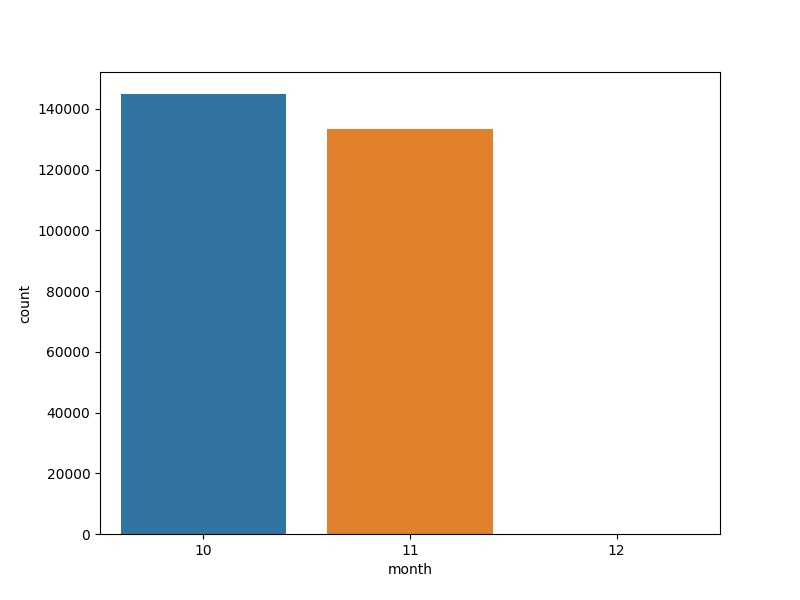

In [182]:
plt.figure(figsize=(8,6))
sns.barplot(x='month', y='count', data=group_month)
%matplot plt

In [183]:
group_weekday = spark.sql(
    '''
    SELECT weekday, COUNT(*) AS count
    FROM datetime_data
    GROUP BY weekday
    '''
).toPandas()

group_weekday

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   weekday  count
0        1  47364
1        6  21050
2        3  44320
3        5  28027
4        4  48173
5        2  45968
6        0  43252

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

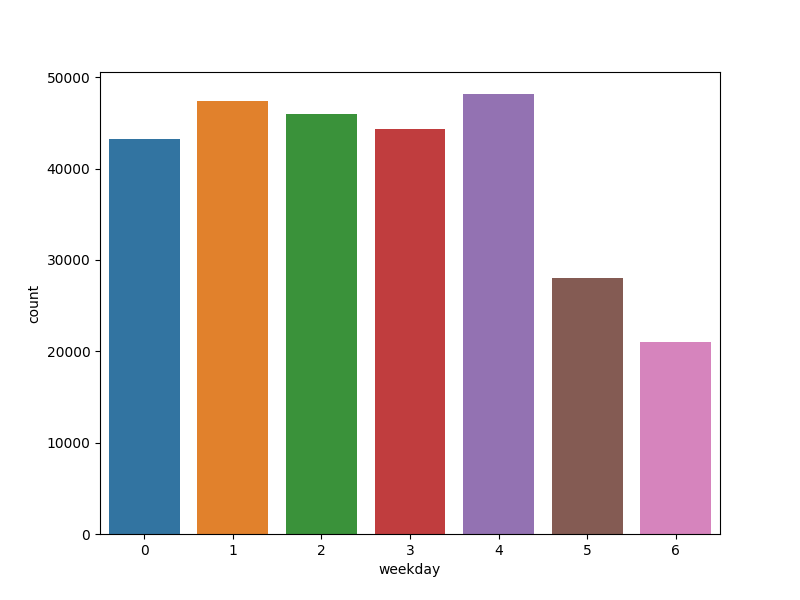

In [184]:
plt.figure(figsize=(8,6))
sns.barplot(x='weekday', y='count', data=group_weekday)
%matplot plt

In [185]:
group_day = spark.sql(
    '''
    SELECT day, COUNT(*) AS count
    FROM datetime_data
    GROUP BY day
    '''
).toPandas()

group_day

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    day  count
0    31   5102
1    28   6825
2    26  10117
3    27   9615
4    12   8964
5    22   8025
6     1  11298
7    13   7855
8    16  11007
9     6   8372
10    3   7934
11   20  10882
12    5   8505
13   19  10122
14   15  10882
15    9  11292
16   17   7632
17    4   7059
18    8   9028
19   23   9866
20    7   7258
21   10   9380
22   25   7836
23   24   8242
24   29   9726
25   21   9306
26   11   8375
27   14   7171
28    2  11843
29   30  10964
30   18   7671

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

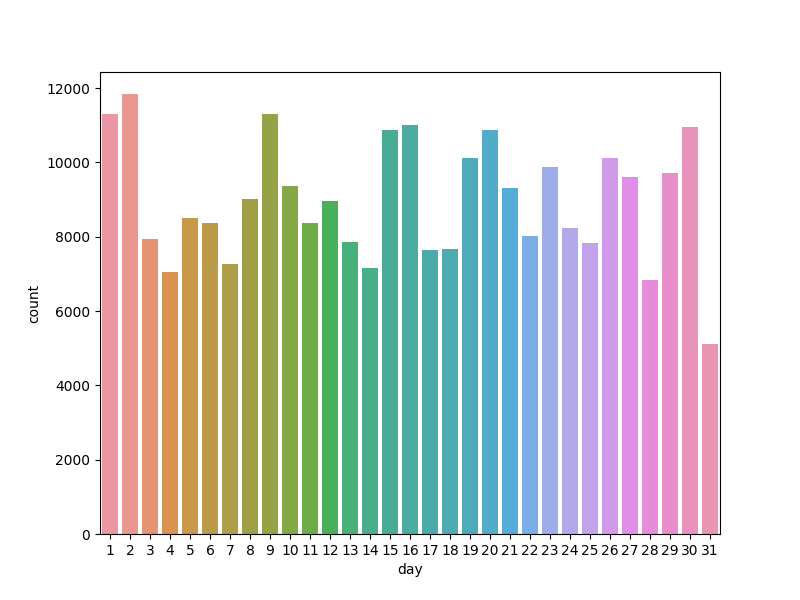

In [186]:
plt.figure(figsize=(8,6))
sns.barplot(x='day', y='count', data=group_day)
%matplot plt

In [187]:
group_hour = spark.sql(
    '''
    SELECT hour, COUNT(*) AS count
    FROM datetime_data
    GROUP BY hour
    '''
).toPandas()

group_hour

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    hour  count
0     12  11459
1     22  12254
2      1  10149
3     13  11846
4      6   9801
5     16  14297
6      3  10126
7     20  13215
8      5  10009
9     19  13366
10    15  13936
11     9  10217
12    17  14082
13     4   9954
14     8  10000
15    23  11778
16     7   9801
17    10  10789
18    21  12688
19    11  10779
20    14  12835
21     2  10095
22     0  11079
23    18  13599

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

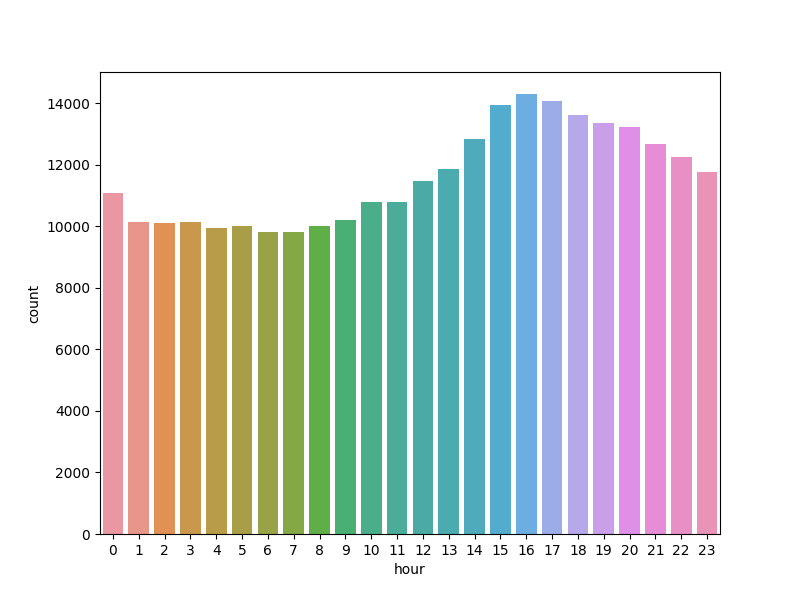

In [188]:
plt.figure(figsize=(8,6))
sns.barplot(x='hour', y='count', data=group_hour)
%matplot plt

In [16]:
# Find Cancellation and mark churn
churn_sql = spark.sql(
    '''
    SELECT u.*,
        (CASE WHEN c.userId IS null THEN 0
              ELSE 1
         END) AS churn
    FROM clean_sql AS u
    LEFT JOIN 
    (SELECT userId 
     FROM clean_sql
     WHERE page = 'Cancellation Confirmation') AS c
    ON u.userId = c.userId
    '''
)

churn_sql.createOrReplaceTempView('churn_sql')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [190]:
churn_sql.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|         artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|     Ron Carter|Logged In| Darianna|     F|            0|Carpenter|497.13587| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|      133| I CAN'T GET STARTED|   200|1541411290000|"Mozilla/5.0 (iPh...|100010|    0|
|      Limi-T 21|Logged In| Darianna|     F|            1|Carpenter|254.79791| free|Bridgeport-Stamf

In [191]:
# Explore Churn
spark.sql(
    '''
    SELECT churn, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn
    '''
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+

In [17]:
# total_activity
total_activity = spark.sql(
    '''
    SELECT a.userId, a.total_activity, c.churn
    FROM (SELECT userId, COUNT(*) AS total_activity
          FROM clean_sql
          GROUP BY userId) AS a
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON a.userId=c.userId
    '''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [193]:
# churn=0 tends to have less activities
total_activity_df = total_activity.toPandas()
total_activity_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     userId  total_activity  churn
0    100010             381      0
1    200002             474      0
2       125              11      1
3       124            4825      0
4        51            2464      1
..      ...             ...    ...
220      45            1776      0
221      57             112      0
222  200021            1502      1
223     119             223      0
224  100001             187      1

[225 rows x 3 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

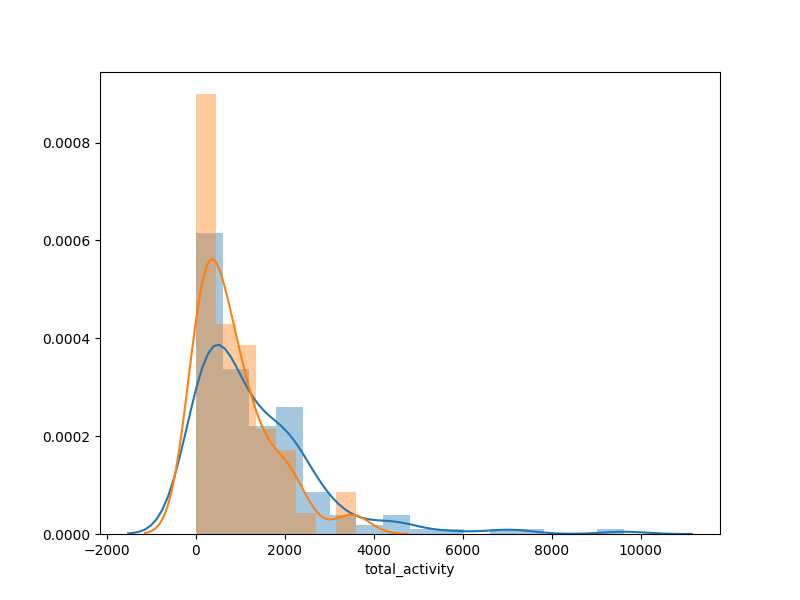

In [194]:
plt.figure(figsize=(8,6))
sns.distplot(
    total_activity_df[total_activity_df['churn'] == 0]['total_activity'])
sns.distplot(
    total_activity_df[total_activity_df['churn'] == 1]['total_activity'])
%matplot plt

In [18]:
total_activity.createOrReplaceTempView('total_activity')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [196]:
# Churn * Auth

churn_auth = spark.sql(
    '''
    SELECT churn, auth, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, auth
    '''
).toPandas()

churn_auth

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churn       auth  count
0      1  Cancelled     52
1      0  Logged In    173
2      1  Logged In     52

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

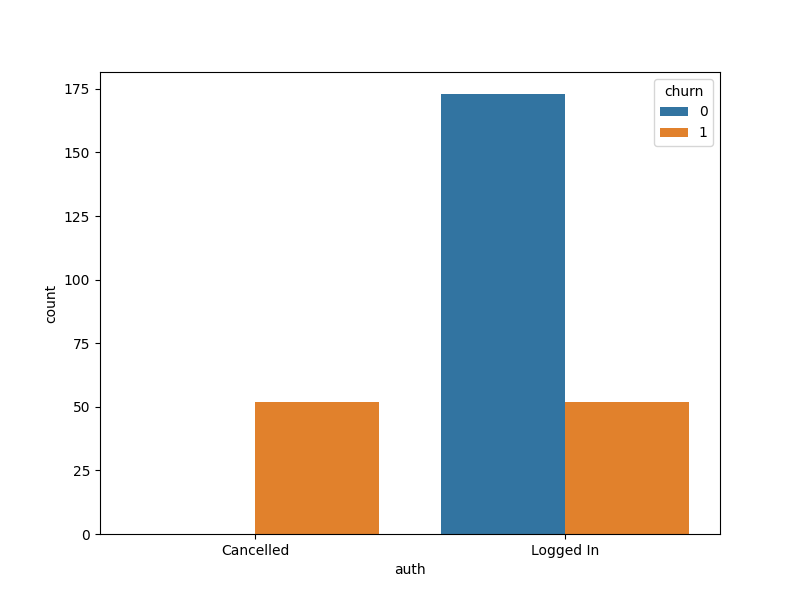

In [197]:
# churn users never cancel login
plt.figure(figsize=(8,6))
sns.barplot(x='auth', y='count', hue='churn', data=churn_auth)
%matplot plt

In [198]:
# churn * gender
churn_gender = spark.sql(
    '''
    SELECT churn, gender, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, gender
    '''
).toPandas()

churn_gender

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churn gender  count
0      1      F     20
1      0      M     89
2      1      M     32
3      0      F     84

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

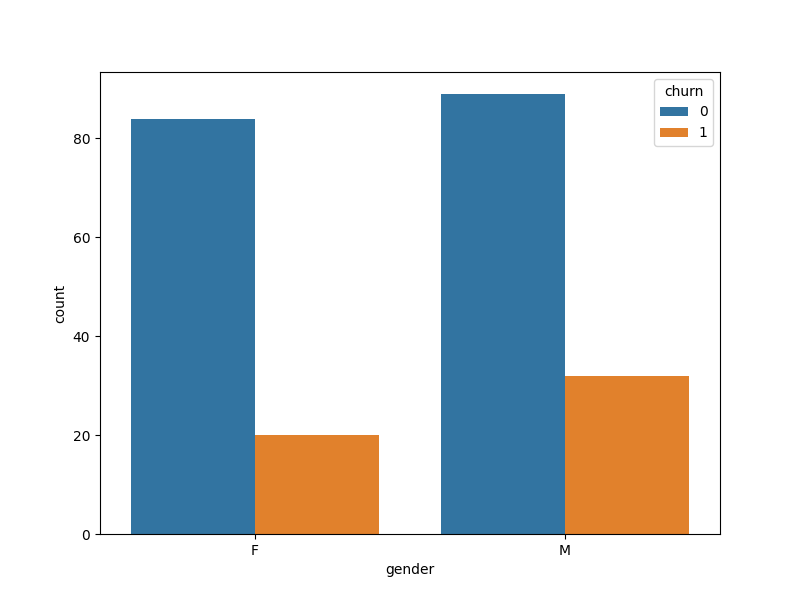

In [199]:
# Man cancels more that woman
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='count', hue='churn', data=churn_gender)
%matplot plt

In [200]:
# churn * gender
churn_level = spark.sql(
    '''
    SELECT churn, level, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, level
    '''
).toPandas()

churn_level

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churn level  count
0      0  free    149
1      0  paid    129
2      1  paid     36
3      1  free     46

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

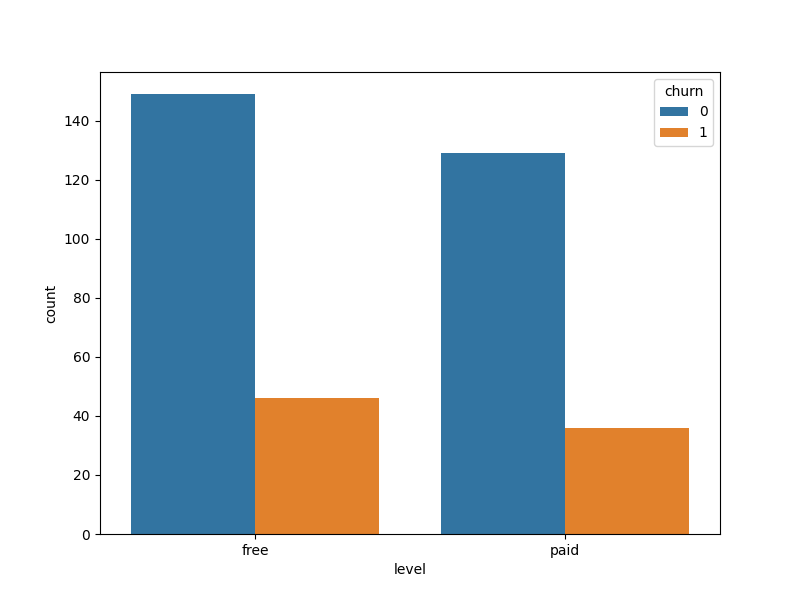

In [201]:
# Free users are easier to quit.
plt.figure(figsize=(8,6))
sns.barplot(x='level', y='count', hue='churn', data=churn_level)
%matplot plt

In [202]:
# churn * page
churn_page = spark.sql(
    '''
    SELECT churn, page, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, page
    '''
).toPandas()

churn_page

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    churn                       page  count
0       0              Save Settings    102
1       1                     Logout     46
2       0           Submit Downgrade     40
3       0                   NextSong    173
4       1              Save Settings     30
5       0                 Add Friend    162
6       1                Roll Advert     50
7       0                      Error     95
8       0            Add to Playlist    165
9       0                      About    124
10      1                   Settings     43
11      1             Submit Upgrade     29
12      0                  Thumbs Up    170
13      1  Cancellation Confirmation     52
14      1            Add to Playlist     50
15      1                   NextSong     52
16      1                       Home     51
17      1                    Upgrade     37
18      0                Thumbs Down    155
19      1           Submit Downgrade      9
20      1                       Help     43
21      1                 Add Fr

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

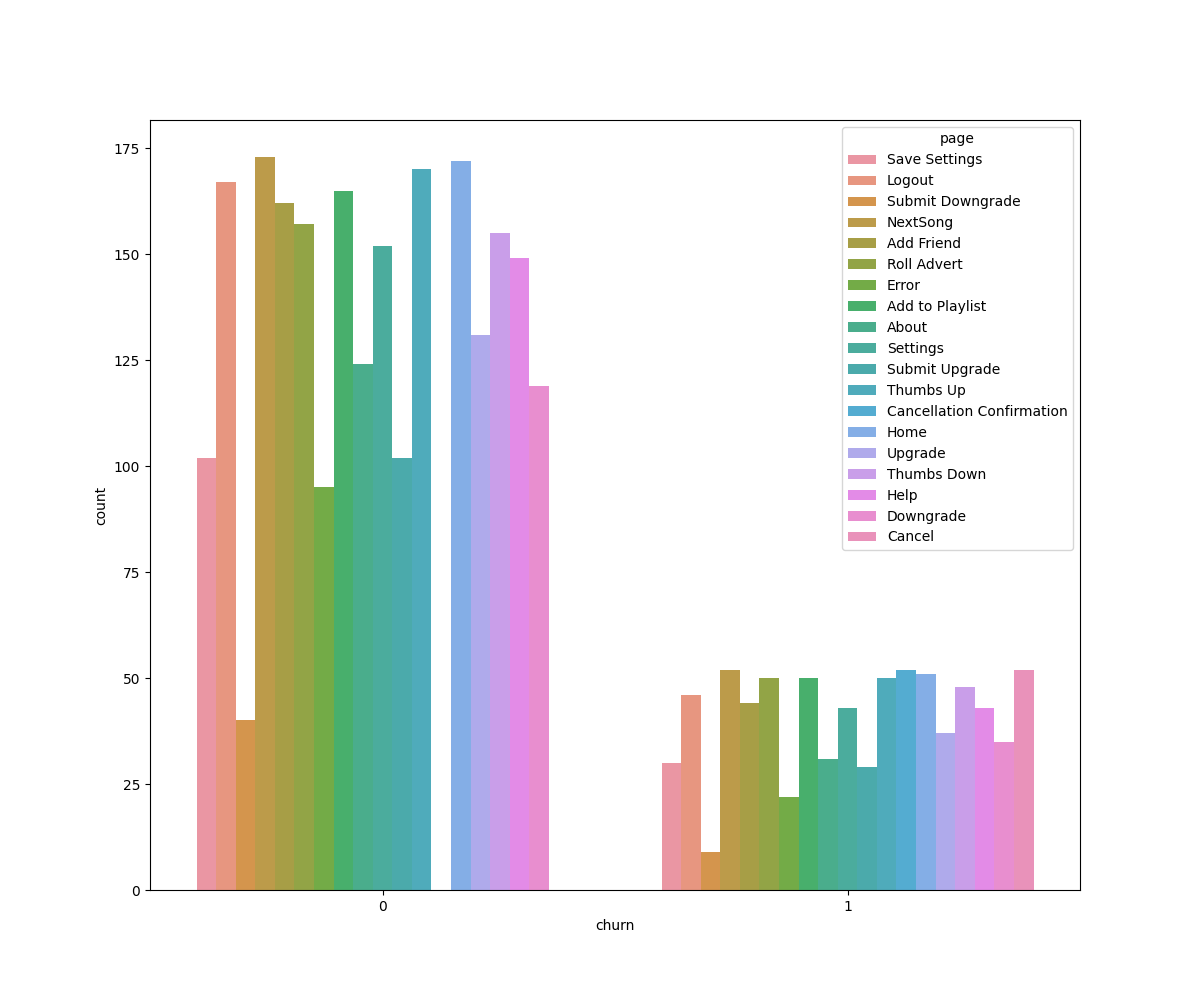

In [203]:
plt.figure(figsize=(12,10))
sns.barplot(x='churn', y='count', hue='page', data=churn_page)
%matplot plt

In [204]:
# churn*month
churn_month = spark.sql(
    '''
    SELECT churn, CAST(month(ts) AS INT) AS M, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, M
    '''
).toPandas()

churn_month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churn   M  count
0      1  11     22
1      0  10    161
2      0  11    165
3      1  10     52
4      0  12      4

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

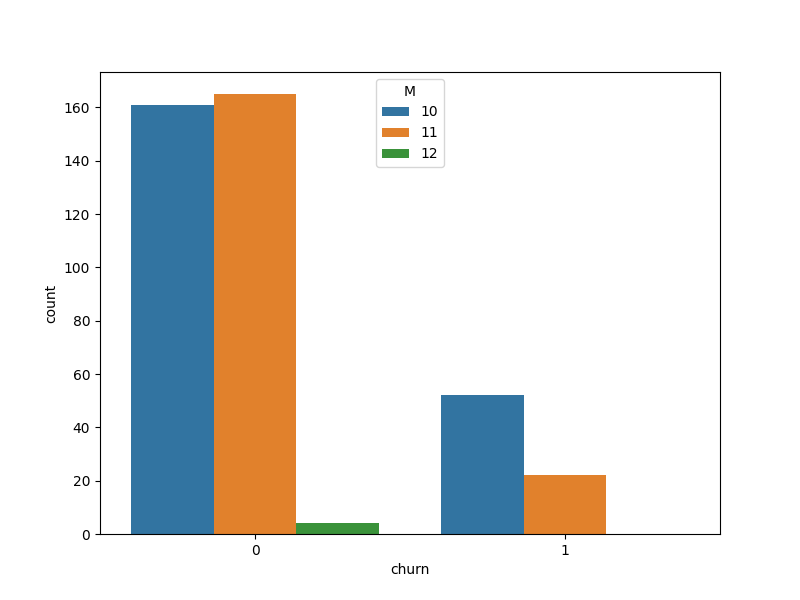

In [205]:
# far more quit in October, the first month
plt.figure(figsize=(8, 6))
sns.barplot(x='churn', y='count', hue='M', data=churn_month)
%matplot plt

In [206]:
# churn*weekday
churn_weekday = spark.sql(
    '''
    SELECT churn, CAST(weekday(ts) AS INT) AS W, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, W
    '''
).toPandas()
churn_weekday

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    churn  W  count
0       1  0     36
1       1  2     36
2       0  5    107
3       1  1     34
4       1  3     39
5       0  0    139
6       1  4     43
7       0  1    141
8       1  5     38
9       0  6    109
10      0  2    143
11      0  3    139
12      1  6     24
13      0  4    147

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

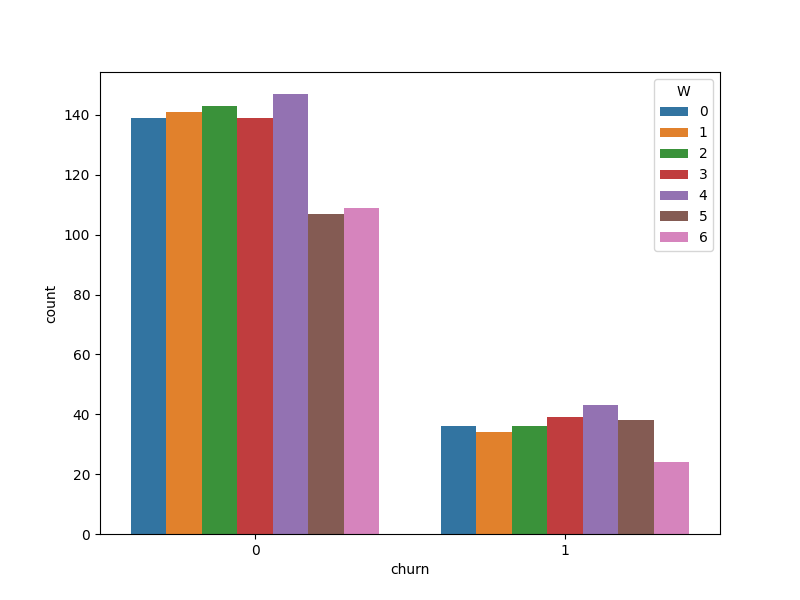

In [207]:
plt.figure(figsize=(8, 6))
sns.barplot(x='churn', y='count', hue='W', data=churn_weekday)
%matplot plt

In [208]:
# churn*weekday
churn_day = spark.sql(
    '''
    SELECT churn, CAST(day(ts) AS INT) AS D, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, D
    '''
).toPandas()
churn_day

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    churn   D  count
0       0  25     66
1       1  25     10
2       0  13     60
3       0  20     66
4       1   7     15
..    ...  ..    ...
57      1  10     21
58      0   4     60
59      0  12     63
60      0  21     75
61      0  23     72

[62 rows x 3 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

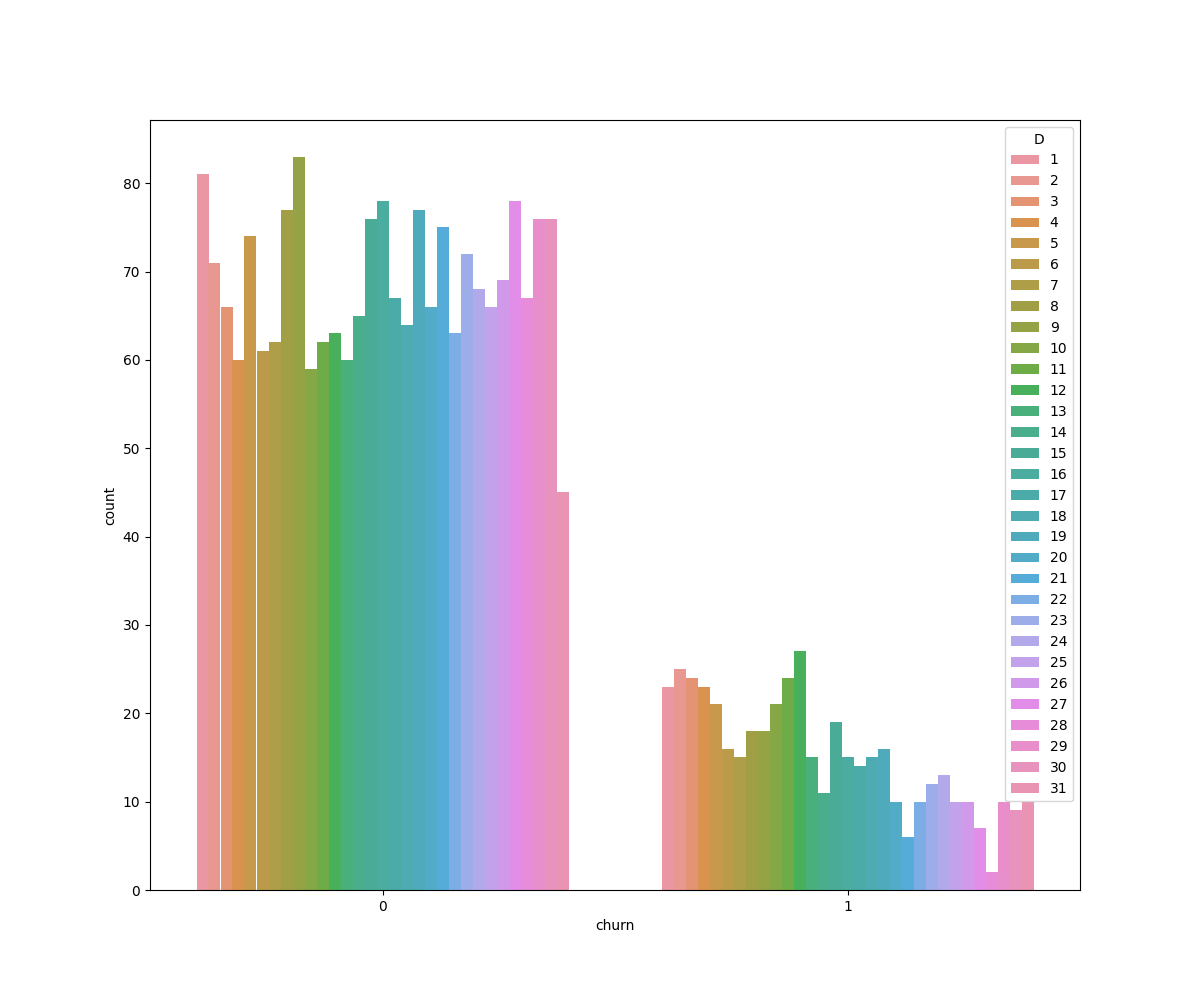

In [209]:
# higher quit in first half of month, sharp difference between weekdays and weekends
plt.figure(figsize=(12, 10))
sns.barplot(x='churn', y='count', hue='D', data=churn_day)
%matplot plt

In [210]:
# churn*weekday
churn_hour = spark.sql(
    '''
    SELECT churn, CAST(hour(ts) AS INT) AS H, count(DISTINCT userId) as count
    FROM churn_sql
    GROUP BY churn, H
    '''
).toPandas()
churn_hour

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    churn   H  count
0       1   0     36
1       0  13    148
2       0  20    138
3       1   7     37
4       1  20     40
5       0  14    149
6       1   2     36
7       0   7    137
8       1   9     34
9       0   5    137
10      1  22     38
11      1   1     34
12      1   3     32
13      0  22    142
14      1  11     36
15      0  16    147
16      0   0    137
17      1   4     35
18      0  10    136
19      0  17    146
20      1   8     35
21      1  16     42
22      1  19     42
23      1  23     38
24      0   9    132
25      0  15    153
26      0  18    142
27      1  18     43
28      1  14     40
29      0  11    138
30      1  21     40
31      0   1    138
32      0  19    142
33      1  17     42
34      1  12     37
35      0   8    130
36      1   5     35
37      1  15     41
38      0   6    138
39      0   2    141
40      1  13     39
41      0   3    139
42      1   6     37
43      1  10     34
44      0   4    137
45      0  12    145
46      0  21

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

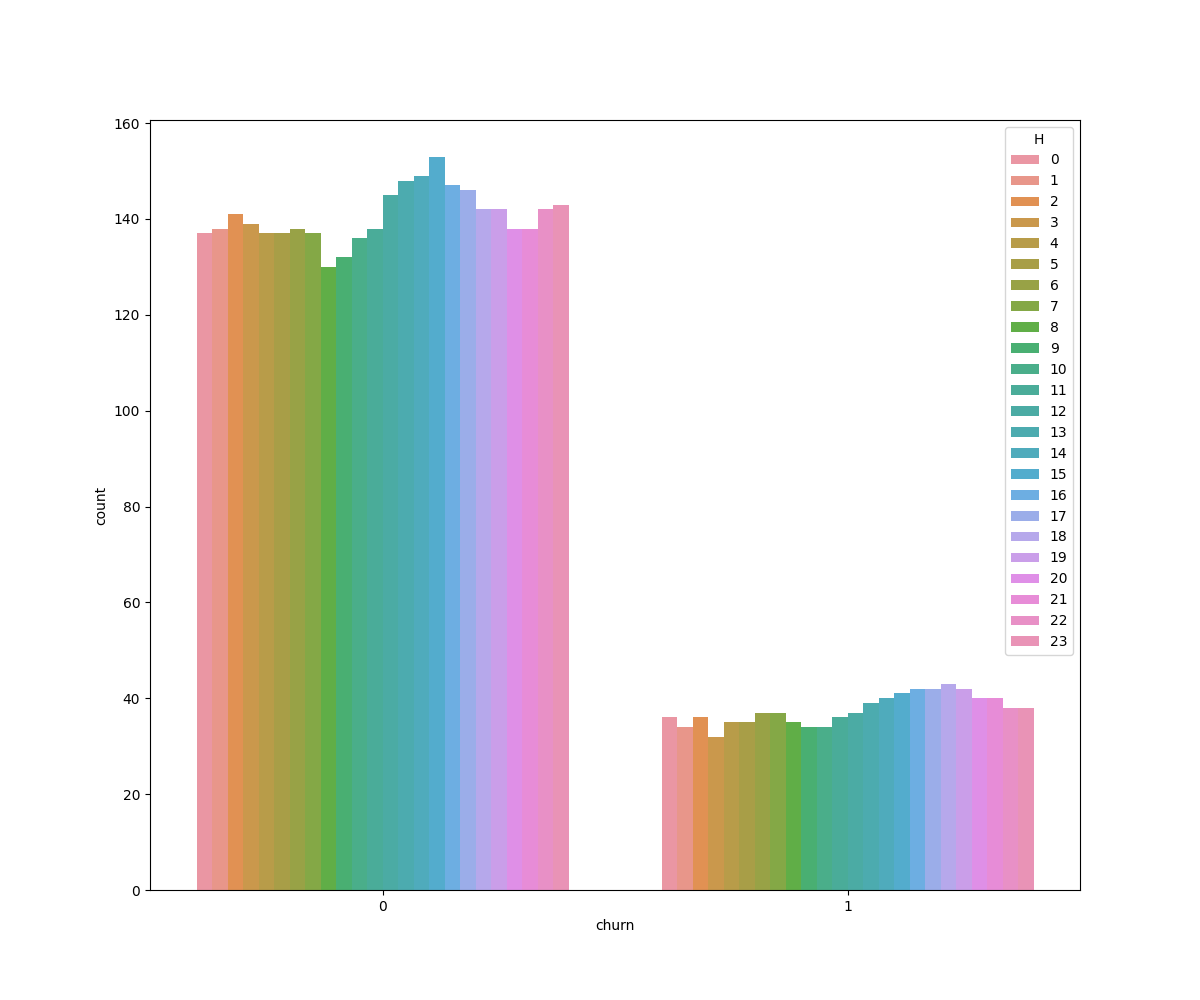

In [211]:
# higher quit in first half of month
plt.figure(figsize=(12, 10))
sns.barplot(x='churn', y='count', hue='H', data=churn_hour)
%matplot plt

In [19]:
# churn * registration
churn_registration = spark.sql(
    '''
    SELECT d.userId, registration_days, c.churn
    FROM (SELECT userId, DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) AS registration_days
          FROM datetime_data
          GROUP BY userId) as d 
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON d.userId=c.userId
               
    '''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [213]:
# Churn=1 are more left skewed.
churn_registration_df = churn_registration.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

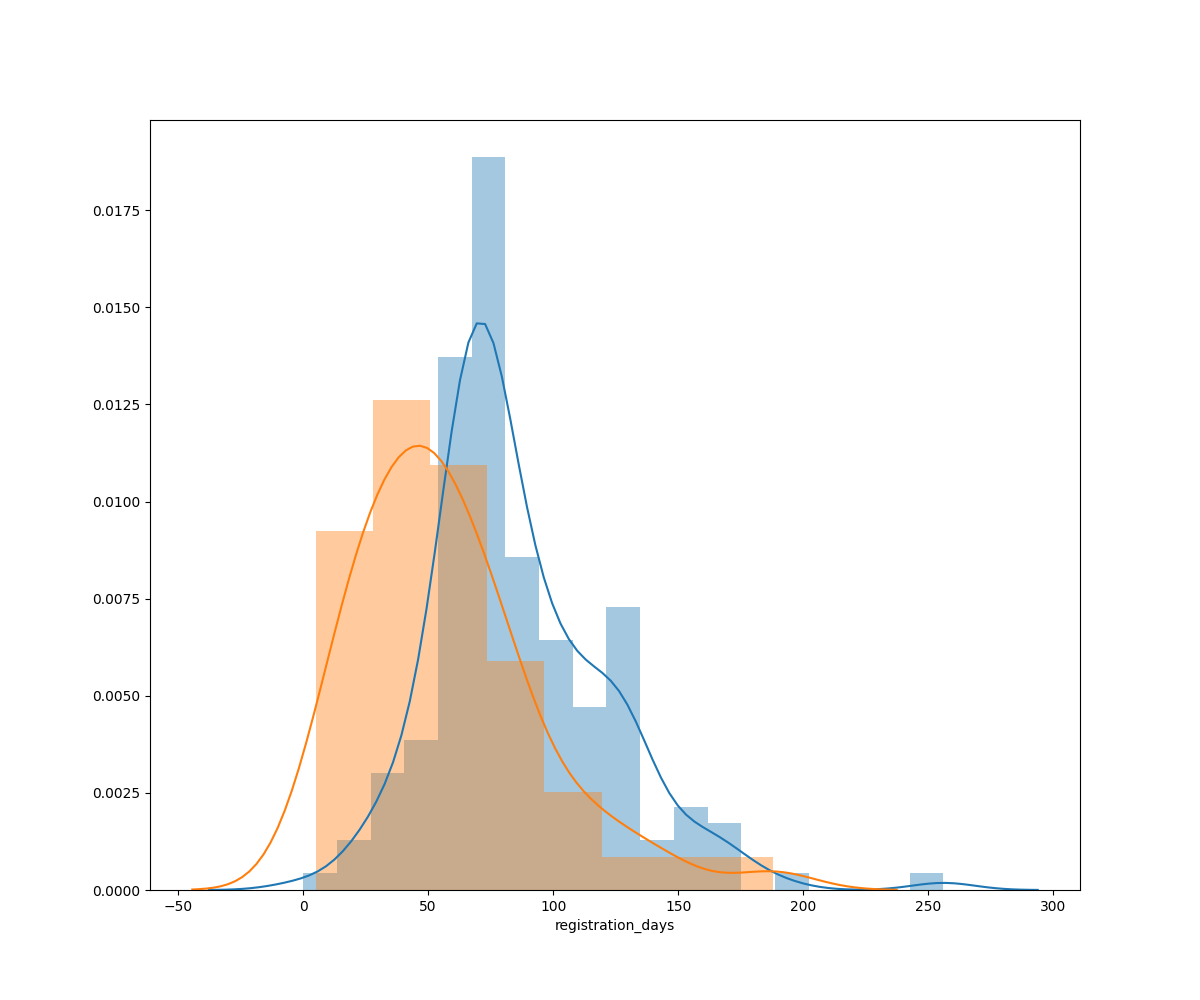

In [214]:
plt.figure(figsize=(12, 10))
sns.distplot(
    churn_registration_df[churn_registration_df['churn'] == 0]['registration_days'])
sns.distplot(
    churn_registration_df[churn_registration_df['churn'] == 1]['registration_days'])
%matplot plt

In [20]:
churn_registration.createOrReplaceTempView('churn_registration')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# churn*last week activity
churn_week_count = spark.sql(
    '''
    SELECT w.userId, w.week_count, c.churn
    FROM
    (
        SELECT d.userId, COUNT(d.userId) AS week_count        
        FROM datetime_data d
        JOIN 
        (
            SELECT userId, MAX(datetime_page) AS last_datetime
            FROM datetime_data
            GROUP BY userId
        ) AS l
        ON l.userId = d.userId
        WHERE d.datetime_page >= DATE_SUB(l.last_datetime, 7)
        GROUP BY d.userId
    ) AS w
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON w.userId=c.userId
    '''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [217]:
# churn=0 not active in the last week
churn_week_count_df = churn_week_count.toPandas()
churn_week_count_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     userId  week_count  churn
0    100010          33      0
1    200002         140      0
2       125          11      1
3       124         301      0
4        51        1099      1
..      ...         ...    ...
220      45         612      0
221      57          50      0
222  200021         402      1
223     119          16      0
224  100001         187      1

[225 rows x 3 columns]

In [218]:
(churn_week_count_df[churn_week_count_df['churn'] == 0]['week_count'].mean(
), churn_week_count_df[churn_week_count_df['churn'] == 1]['week_count'].mean())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(269.1098265895954, 333.63461538461536)

In [22]:
churn_week_count.createOrReplaceTempView('churn_week_count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
churn_artist_count = spark.sql(
    '''
    SELECT a.userId, a.artist_count, c.churn
    FROM (SELECT userId, COUNT(DISTINCT artist) AS artist_count
          FROM clean_sql
          GROUP BY userId) AS a
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON a.userId=c.userId
    '''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [221]:
churn_artist_count_df = churn_artist_count.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
churn_artist_count.createOrReplaceTempView('churn_artist_count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

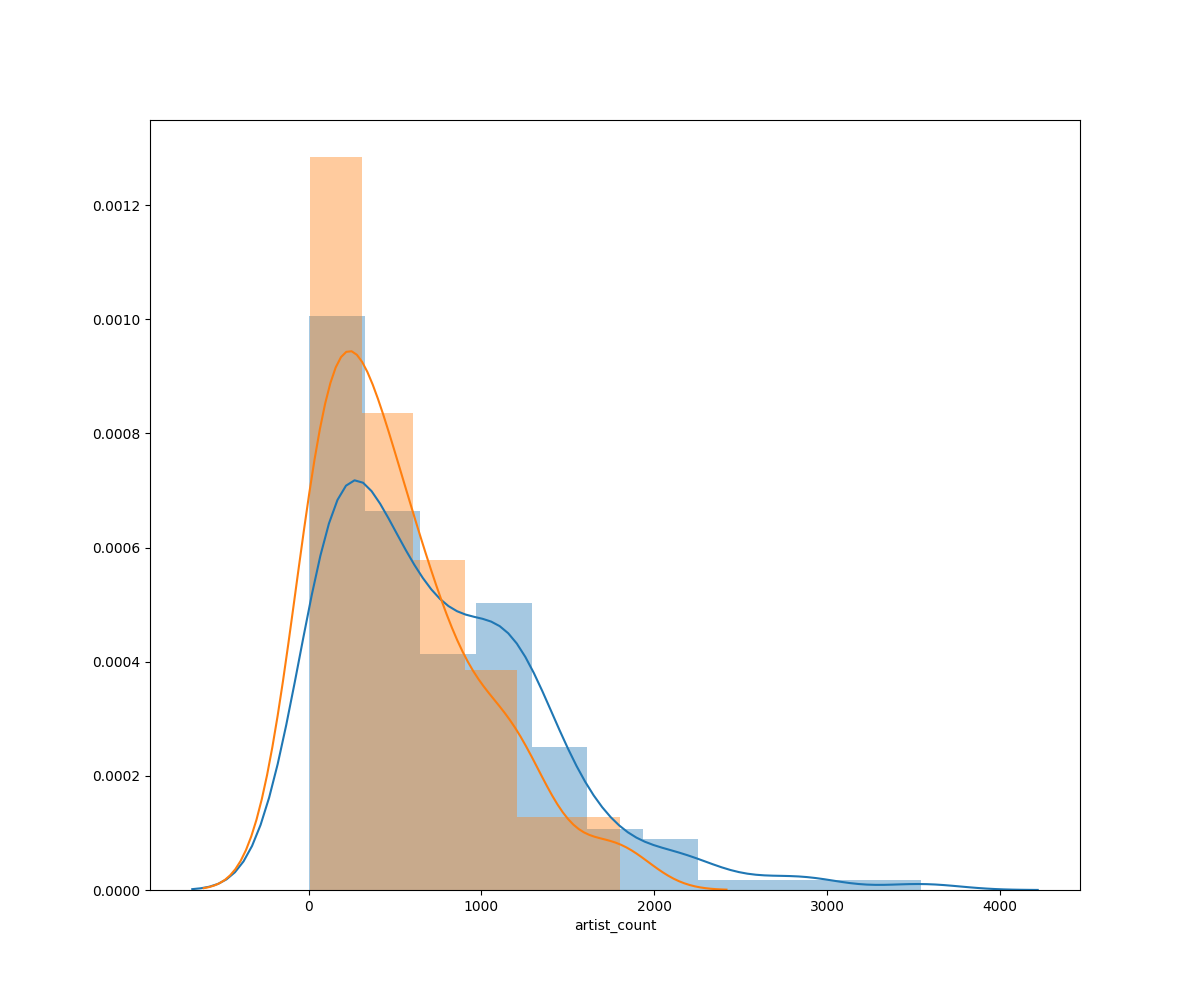

In [223]:
# churn=0 artist tends to be smaller
plt.figure(figsize=(12, 10))
sns.distplot(
    churn_artist_count_df[churn_artist_count_df['churn'] == 0]['artist_count'])
sns.distplot(
    churn_artist_count_df[churn_artist_count_df['churn'] == 1]['artist_count'])
%matplot plt

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [25]:
# From the data exploration, we choose gender, level, page, total_visited_page, artist_count, week_count, registration as independent variables
# we need to extend gender, level and page

extension = ''
for i in ['gender', 'level', 'page']:
    category = spark.sql('''SELECT DISTINCT ''' + i +
                         ''' FROM clean_sql''').toPandas()[i].values
    for j in category:
        extension += ', CASE WHEN ' + i + "= '" + j + \
            "' THEN 1 ELSE 0 END AS " + i + '_' + j.replace(' ', '_')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# extend records into binary nums

extension = '''SELECT userId, churn ''' + extension + ''' FROM churn_sql'''
extension_table = spark.sql(extension)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [226]:
extension_table.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

In [29]:
extension_table.createOrReplaceTempView('extension_table')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# sum up records by users
sumup = ''
for i in ['gender', 'level', 'page']:
    category = spark.sql('''SELECT DISTINCT ''' + i +
                         ''' FROM clean_sql''').toPandas()[i].values
    for j in category:
        sumup += ', SUM(' + i + '_' + j.replace(' ', '_') + \
            ') AS ' + i + '_' + j.replace(' ', '_')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
sumup = '''SELECT userId, SUM(churn) AS churn ''' + \
    sumup + ''' FROM extension_table GROUP BY userId'''

sum_table = spark.sql(sumup)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [230]:
sum_table.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

In [34]:
sum_table.createOrReplaceTempView('sum_table')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# transform the table, make churn, gender, level 0-1
transform = '''SELECT userId, CASE WHEN Churn > 0 THEN 1 ELSE 0 END AS churn'''
for i in sum_table.columns[2:]:
    if i.split('_')[0] == 'page':
        transform += ', '+i
    else:
        transform += ', CASE WHEN '+i+' >0 THEN 1 ELSE 0 END AS '+i

transform += ' FROM sum_table'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
transform_table = spark.sql(transform)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [234]:
transform_table.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

In [37]:
transform_table.createOrReplaceTempView('transform_table')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# bind the table with total_visited_page, artist_count, week_count, registration

final = spark.sql(
    '''
    SELECT transform_table.*,
           churn_registration.registration_days,
           churn_artist_count.artist_count,
           total_activity.total_activity,
           churn_week_count.week_count
    FROM transform_table
    JOIN churn_registration
    ON transform_table.userId=churn_registration.userId
    JOIN churn_artist_count
    ON transform_table.userId=churn_artist_count.userId
    JOIN total_activity
    ON transform_table.userId=total_activity.userId
    JOIN churn_week_count
    ON transform_table.userId=churn_week_count.userId
''')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [109]:
final.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+-----------------+------------+--------------+----------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|registration_days|artist_count|total_activity|week_count|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+-----------------

In [237]:
final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['userId', 'churn', 'gender_F', 'gender_M', 'level_free', 'level_paid', 'page_Cancel', 'page_Submit_Downgrade', 'page_Thumbs_Down', 'page_Home', 'page_Downgrade', 'page_Roll_Advert', 'page_Logout', 'page_Save_Settings', 'page_Cancellation_Confirmation', 'page_About', 'page_Settings', 'page_Add_to_Playlist', 'page_Add_Friend', 'page_NextSong', 'page_Thumbs_Up', 'page_Help', 'page_Upgrade', 'page_Error', 'page_Submit_Upgrade', 'registration_days', 'artist_count', 'total_activity', 'week_count']

In [39]:
final.createOrReplaceTempView('final')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
no_id = '''SELECT '''
for i in final.columns[1:]:
    no_id += i+','

no_id = no_id[:-1]+''' FROM final'''

final = spark.sql(no_id)
final.createOrReplaceTempView('final')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
final.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+-----------------+------------+--------------+----------+
|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|registration_days|artist_count|total_activity|week_count|
+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+-------------------

In [114]:
final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['churn', 'gender_F', 'gender_M', 'level_free', 'level_paid', 'page_Cancel', 'page_Submit_Downgrade', 'page_Thumbs_Down', 'page_Home', 'page_Downgrade', 'page_Roll_Advert', 'page_Logout', 'page_Save_Settings', 'page_Cancellation_Confirmation', 'page_About', 'page_Settings', 'page_Add_to_Playlist', 'page_Add_Friend', 'page_NextSong', 'page_Thumbs_Up', 'page_Help', 'page_Upgrade', 'page_Error', 'page_Submit_Upgrade', 'registration_days', 'artist_count', 'total_activity', 'week_count']

In [42]:
final.write.save('finals.json',format='json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [9]:
final= spark.read.json('finals.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
cols=['artist_count', 'gender_F', 'gender_M', 'level_free', 'level_paid', 'page_About', 'page_Add_Friend', 'page_Add_to_Playlist', 'page_Downgrade', 'page_Error', 'page_Help', 'page_Home', 'page_Logout', 'page_NextSong', 'page_Roll_Advert', 'page_Save_Settings', 'page_Settings', 'page_Submit_Downgrade', 'page_Submit_Upgrade', 'page_Thumbs_Down', 'page_Thumbs_Up', 'page_Upgrade', 'registration_days', 'total_activity', 'week_count']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Vector Assembler

assembler = VectorAssembler(inputCols=cols, outputCol='features')
df = assembler.transform(final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df.show(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+--------+--------+----------+----------+----------+---------------+--------------------+-----------+------------------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+-----------------+--------------+----------+--------------------+
|artist_count|churn|gender_F|gender_M|level_free|level_paid|page_About|page_Add_Friend|page_Add_to_Playlist|page_Cancel|page_Cancellation_Confirmation|page_Downgrade|page_Error|page_Help|page_Home|page_Logout|page_NextSong|page_Roll_Advert|page_Save_Settings|page_Settings|page_Submit_Downgrade|page_Submit_Upgrade|page_Thumbs_Down|page_Thumbs_Up|page_Upgrade|registration_days|total_activity|week_count|            features|
+------------+-----+--------+--------+----------+----------+----------+---------------+--------------------+-----------+----------------------------

In [13]:
# Standard Scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='features_scale', withStd=True)
df = scaler.fit(df).transform(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# select features and churn label
df = df.select(df.churn.alias('label'), df.features_scale.alias('features'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[1.21367287126071...|
|    0|[2.01009395049181...|
|    0|[1.88260034737166...|
|    0|(25,[0,1,3,6,11,1...|
|    0|(25,[0,2,3,10,11,...|
|    0|[2.72041545358983...|
|    0|[1.82133718743080...|
|    0|[4.66759048306131...|
|    1|[1.22691895989657...|
|    0|[1.92565013543820...|
|    1|[0.60932007724957...|
|    0|[0.91563587695385...|
|    0|[2.18394886383748...|
|    1|[1.38090474028844...|
|    0|[0.21690470141221...|
|    0|[1.55475965363411...|
|    0|[1.36600289057310...|
|    0|[3.69565872940505...|
|    1|[2.29322909508333...|
|    0|[0.23511807328652...|
+-----+--------------------+
only showing top 20 rows

In [52]:
# split train, test and validation
train, test = df.randomSplit([0.7, 0.3])
valid, test = test.randomSplit([0.5, 0.5])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# Logistic Regression
lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = ParamGridBuilder().build()
cv = CrossValidator(estimator=lr,
                    evaluator=evaluator,
                    estimatorParamMaps=param_grid,
                    numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
cv_fit=cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
lr_pred=cv_fit.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
# show cv performance
print('Accuracy: ', evaluator.evaluate(
    lr_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(lr_pred, {evaluator.metricName: 'f1'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy:  0.7045454545454546
F1 Score:  0.7101795991956175

In [57]:
# using best model of cv to validate
lr_best = cv_fit.bestModel
lr_best.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='LogisticRegression_3b42a167ab26', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_3b42a167ab26', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LogisticRegression_3b42a167ab26', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_3b42a167ab26', name='featuresCol', doc='features column name'): 'features', Param(parent='LogisticRegression_3b42a167ab26', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_3b42a167ab26', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticRegression_3b42a167ab26', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, P

In [58]:
# using best model of cv to validate
lr_valid = cv_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(
    lr_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(lr_valid, {evaluator.metricName: 'f1'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy:  0.8571428571428571
F1 Score:  0.8658008658008657

In [59]:
# Gradient Boosting
gb = GBTClassifier(seed=0)
param_grid_gb = ParamGridBuilder().build()
cv_gb = CrossValidator(estimator=gb,
                       evaluator=evaluator,
                       estimatorParamMaps=param_grid_gb,
                       numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# fit train and predict test
gb_fit=cv_gb.fit(train)
gb_pred = gb_fit.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
# show cv performance
print('Accuracy: ', evaluator.evaluate(
    gb_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(gb_pred, {evaluator.metricName: 'f1'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy:  0.6590909090909091
F1 Score:  0.6514649393688333

In [62]:
# using best model of cv to validate
gb_valid = gb_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(
    gb_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(gb_valid, {evaluator.metricName: 'f1'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy:  0.8928571428571429
F1 Score:  0.9014822386915411

In [63]:
# SVM
svc = LinearSVC()
param_grid_svc = ParamGridBuilder().build()
cv_svc = CrossValidator(estimator=svc,
                        evaluator=evaluator,
                        estimatorParamMaps=param_grid_svc,
                        numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
# fit train and predict test
svc_fit=cv_svc.fit(train)
svc_pred = svc_fit.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-63:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 14299



In [65]:
# show cv performance
print('Accuracy: ', evaluator.evaluate(
    svc_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(svc_pred, {evaluator.metricName: 'f1'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy:  0.6818181818181818
F1 Score:  0.6449631449631449

In [66]:
# using best model of cv to validate
#svc_best = gb.bestModel
#svc_best.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# using best model of cv to validate
svc_valid = svc_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(
    svc_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(
    svc_valid, {evaluator.metricName: 'f1'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy:  0.8571428571428571
F1 Score:  0.8658008658008657

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.